In [1]:
import sys 
import os
sys.path.append(os.path.abspath("..")) # so we can find didson.py, multibeam.py

from glob import glob           # file manipulation
import numpy as np
from skimage.io import imread, imsave  # image processin
from scipy.stats import cauchy, norm #chi2, erlang, expon, genexpon, ncx2, poisson, powerlaw, rayleigh


import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
image_list = sorted(glob('../data/dataset-1/*raw.png'))
print len(image_list)

import cv2
from sonar import Sonar
from didson import Didson

didson = Didson();
didson.load_config('../data/DIDSON/didson.json')

10


In [3]:
def initialize(y,t):
    """Compute the initial label assignment."""
    yt = np.copy(y)
    yt[yt<t]=0.0
    x = np.argmax(yt,0)
    r = np.linspace(2.25,11.75,512)
    return(r[x])

def predict(x):
    """Predict the image, based on the current labels"""
    N = len(x)
    r = np.linspace(2.25,11.75,512)
    yp = np.zeros((512,N))
    for b in range(0,N):
        yp[:,b] = cauchy.pdf(r, loc=x[b], scale=0.05)
        yp[:,b]/=np.amax(yp)

    return(yp)

image: 4
0.0 0.741176470588
(512, 96)


(-0.5, 511.5, 95.5, -0.5)

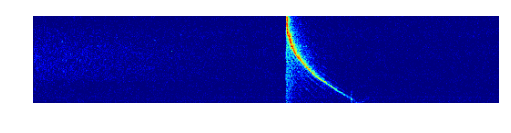

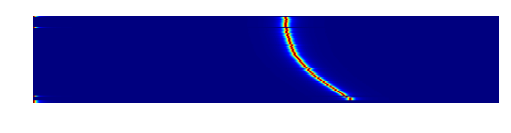

In [189]:
# image_list = sorted(glob('/home/pvt/data/pings/raw/*.png'))
idx = np.random.randint(0,len(image_list))

print 'image:',idx
# img = imread(image_list[idx], as_grey=True)
ping = cv2.imread(image_list[idx],cv2.CV_LOAD_IMAGE_GRAYSCALE).astype(np.float64)
ping/=255.0
y = didson.deconvolve(ping)

# img = ping
# img = img.astype(np.float64)/255.0
print np.amin(y), np.amax(y)
print img.shape
plt.imshow(ping.transpose())
plt.axis('off')

xi = initialize(y,0.3)


yp = predict(xi)
plt.figure()
plt.imshow(yp.transpose())
plt.axis('off')


In [188]:
def getComponent(x):
    comp = []
    rem = []
    begin = np.where(x>2.25)[0]
    if len(begin)>0:
        begin = begin[0]
        length =np.where(x[begin:-1]<=2.25)[0]
        if len(length)<1:
            # all the elements till the end
            comp = x[begin:] # OK!
        else:
            length = length[0]
            comp = x[begin:(begin+length)]
            rem = x[begin+length:]
        
    return (comp, begin, rem)
    
def components(x):
    xc = np.copy(x)
    l = [] # component
    i = [] # where does the component begin in the original vector
    n = len(xc)
    while True:
        m = len(xc)
        (c, b, xc) = getComponent(xc)
        if len(c)<1:
            break
        i.append(n-m+b)
        l.append(c)
        if len(xc)<1:
            break
    return(l,i)

l,idx = components(xi)
print 'components:'
for c in range(0,len(l)):
    print '\tcomponent',c, '-',len(l[c]),'elements'
    print '\t',unary_cost(l[c],y[:,idx[c]:(idx[c]+len(l[c]))])
    print '\t',5e3*binary_cost(l[c],1.0)

components:
	component 0 - 1 elements
	0.247202736963
	0.0
	component 1 - 7 elements
	1.70832715793
	7772.95029709
	component 2 - 2 elements
	0.480399012463
	0.0
	component 3 - 1 elements
	0.237735845602
	0.0
	component 4 - 2 elements
	0.483079882016
	706.865170382
	component 5 - 5 elements
	1.2652125929
	11655.8846558
	component 6 - 5 elements
	1.26549864906
	5723.58999802
	component 7 - 1 elements
	0.233274285255
	0.0
	component 8 - 2 elements
	0.48242291443
	2593.68875354
	component 9 - 25 elements
	8.44846690502
	24203.3234684


In [171]:
def perturb(x, sigma=0.2):
    """Randomly perturb a solution vector."""
    xp = np.copy(x)
    # randomly select index
    idx = np.random.randint(0,len(xp))
    # perturb selected index by random amount
    xp[idx] += sigma*np.random.randn()

    return(xp)
    
def solve(x0, y,wu,wb,N):
    """Compute range measurements through simulated annealing.
    
    Arguments:
    y -- the input image
    wu -- unary cost weight
    wb -- binary cost weight
    N -- Number of iterations
    
    Note: the cost weights should be initialized so that they're comparable.
    There's an upper bound of B-1 on the total binary cost.
    """
    x = np.copy(x0)
    cost = 1e20       # initial cost
    t0 = 1            # initial temperature
    cl = np.zeros(N)
    
    for i in range(0,N):
        # compute temperature
        t = t0/(np.log(max(i,1)))
        
        # candidate solution
        xc = perturb(x,0.02)
        ci = wu*unary_cost(xc, y) + wb*binary_cost(xc, 1e-1)
                
        # check for improvement
        delta = ci-cost # new - old
        if (delta < 0):
            #  lower cost, keep it
            x = np.copy(xc)
            cost = ci
        else:
            # accept higher cost with decreasing likelihood
            s = np.exp(-delta/t)
            if np.random.rand() < s :
                x = np.copy(xc)
                cost = ci
                
            
        cl[i] = cost
    
    print 'unary:  ', wu*np.sum(unary_cost(x,y))
    print 'binary: ', wb*np.sum(binary_cost(x))
    print 'cost:   ', cost
    print ''
    return(x,cl)
        
    

In [194]:
%%time
from scipy.optimize import basinhopping

def print_fun(x, f, accepted):
        print("at minimum %.4f accepted %d" % (f, int(accepted)))

w = 1.0    # basis width for unary cost function
wu = 1.0   # unary cost weight
wb = 1.0e3 # binary cost weight

niter = 10000

minimizer_kwargs = {"method":"Nelder-Mead","jac":"3-point","hess":"3-point"}

x0, idx = components(xi)
x1 = x0
for i in range(0,len(x0)):
    print 'Segmenting component ',i, '( size=',len(x0[i]),')'
    if 1==len(x0[i]):
        ys = y[:,idx[i]]
        args = (ys)
        minimizer_kwargs = {"method":"Nelder-Mead","args":args}
#         result = basinhopping(unary_cost, x0[i],minimizer_kwargs=minimizer_kwargs,niter=niter)
        xf, c = solve(x0[i], ys, wu, wb, niter)
        print 'initial:',unary_cost(x0[i],ys)
    else:   
        ys = y[:,idx[i]:(idx[i]+len(l[i]))]
        args = (ys,w,wu,wb)
        minimizer_kwargs = {"method":"Nelder-Mead","args":args}
#         result = basinhopping(cost, x0[i],minimizer_kwargs=minimizer_kwargs,niter=niter)
        xf, c = solve(x0[i], ys, wu, wb, niter)

        print 'initial:',cost(x0[i],ys,w,wu,wb)
    x1[i] = xf
    print 'final:',c[-1]
#     x1[i] = result.x
#     print 'final:  ',result.fun
    
    

Segmenting component  0 ( size= 1 )


/home/pvt/anaconda2/envs/multibeam/lib/python2.7/site-packages/ipykernel/__main__.py:30: RuntimeWarning: divide by zero encountered in double_scalars


unary:   0.561450903997
binary:  0.0
cost:    0.561450903997

initial: 0.667020354545
final: 0.561450903997
Segmenting component  1 ( size= 11 )
unary:   6.68478053875
binary:  0.223062727556
cost:    6.90784326631

initial: 11.487346182
final: 6.90784326631
Segmenting component  2 ( size= 74 )
unary:   119.786100871
binary:  24.4179134245
cost:    144.204014295

initial: 170.376465494
final: 144.204014295
Segmenting component  3 ( size= 4 )
unary:   4.81889327434
binary:  0.0199866934613
cost:    4.8388799678

initial: 10.28412255
final: 4.8388799678
CPU times: user 1min 26s, sys: 224 ms, total: 1min 26s
Wall time: 1min 26s


(-0.5, 511.5, 95.5, -0.5)

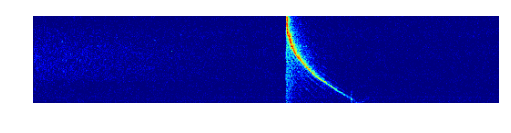

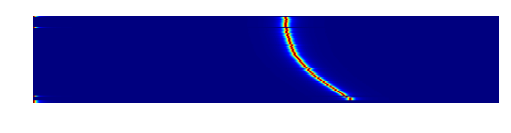

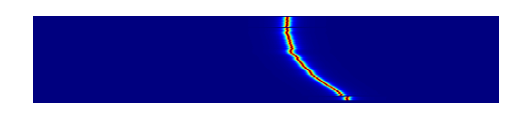

In [191]:
def reconstruct(x0,idx,x1):
    xr = np.zeros(len(x0))
    for i in range(0,len(idx)):

        xr[idx[i]:(idx[i]+len(np.atleast_1d(x1[i])))] = x1[i]
        
    yp = predict(xr)
    return(xr,yp)

(xf,yf) = reconstruct(xi, idx, x1)
plt.figure()
plt.imshow(ping.transpose())
plt.axis('off')
plt.figure()
plt.imshow(yp.transpose())
plt.axis('off')
plt.figure()
plt.imshow(yf.transpose())
plt.axis('off')


In [88]:
def unary_cost(x,y):
    """Compute the total cost for unary potentials"""
    N = len(x)
    cost = 0
    r = np.linspace(2.25,11.75,512)
    for b in range(0,N):
        # measurement
        y = ping[:,b]
        e = np.sum(y) 
        
        # prediction
        yp = cauchy.pdf(r, loc=x[b], scale=0.02) 
        yp/=np.sum(yp)
        
        cost+=np.sum(np.square(y-yp))
    return cost

def binary_cost(x,w=1.0):
    """Compute the total cost for binary potentials"""
    d = w*np.diff(x)
    c = 1-np.exp(-np.square(d/w))

    return(np.sum(c))

def cost(x,y,w,a,b):
    if (len(x)>1):
        return a*unary_cost(x,y)+b*binary_cost(x,w)
    else:
        return a*unary_cost(x,y)

In [ ]:
    
def perturb(x, sigma=0.2):
    """Randomly perturb a solution vector."""
    xp = np.copy(x)
    # randomly select index
    idx = np.random.randint(0,len(xp))
#     perturb selected index by random amount
    xp[idx] += sigma*np.random.randn()

    return(xp)



def solve(y,wu,wb,N):
    """Compute range measurements through simulated annealing.
    
    Arguments:
    y -- the input image
    wu -- unary cost weight
    wb -- binary cost weight
    N -- Number of iterations
    
    Note: the cost weights should be initialized so that they're comparable.
    There's an upper bound of B-1 on the total binary cost.
    """
    x = initialize(y) # initial solution
#     x = initrandom()
#     x = 8.0*np.ones(96)
    cost = 1e20       # initial cost
    t0 = 1            # initial temperature
    cl = np.zeros(N)
    
    for i in range(0,N):
        # compute temperature
        t = t0/(np.log(max(i,1)))
        
        # candidate solution
        xc = perturb(x,0.02)
        ci = wu*unary_cost(xc, y) + wb*binary_cost(xc, 1e-1)
                
        # check for improvement
        delta = ci-cost # new - old
        if (delta < 0):
            #  lower cost, keep it
            x = np.copy(xc)
            cost = ci
        else:
            # accept higher cost with decreasing likelihood
            s = np.exp(-delta/t)
#             print 's:    ',s
#             print 'delta:',delta

            if np.random.rand() < s :
#                 print 'a'
                x = np.copy(xc)
                cost = ci
                
#         if(0==i%(N/10)):
#             print 'temp:   ', t
#             print 'unary:  ', wu*np.sum(unary_cost(x,y))
#             print 'binary: ', wb*np.sum(binary_cost(x))
#             print 'cost:   ', cost
#             print ''
            
        cl[i] = cost
    
    print 'unary:  ', wu*np.sum(unary_cost(x,y))
    print 'binary: ', wb*np.sum(binary_cost(x))
    print 'cost:   ', cost
    print ''
    return(x,cl)
        
    
    

In [ ]:
idx = np.random.randint(0,len(image_list))

print 'image:',idx
# img = imread(image_list[idx], as_grey=True)
ping = cv2.imread(image_list[idx],cv2.CV_LOAD_IMAGE_GRAYSCALE)
img = didson.deconvolve(ping)
# img = ping
img = img.astype(np.float64)/255.0
print np.amin(img), np.amax(img)
print img.shape
plt.imshow(ping.transpose())
plt.axis('off')

In [ ]:
image_list = sorted(glob('/home/pvt/data/pings/raw/*.png'))

idx = np.random.randint(0,len(image_list))
idx = 2040
print idx
ping = cv2.imread(image_list[idx],cv2.CV_LOAD_IMAGE_GRAYSCALE)
ping = ping.astype(np.float64)/255.0
img = didson.deconvolve(ping)
# img = img.astype(np.float64)/255.0
plt.figure()
plt.imshow(img.transpose())
plt.axis('off')
plt.show()

y = img

plt.figure(figsize=(10,10))
plt.subplot(4,1,1)
plt.imshow(ping.transpose())
plt.axis('off')

plt.subplot(4,1,2)
plt.imshow(y.transpose())
plt.axis('off')

(x,c) = solve(y, 1.0e1, 2.0e4, 5000)

plt.subplot(4,1,3)
plt.imshow(predict(initialize(y)).transpose())
plt.axis('off')

plt.subplot(4,1,4)
plt.imshow(predict(x).transpose())
plt.axis('off')
plt.show()

plt.figure()
plt.plot(initialize(y))
plt.plot(x)
plt.grid()
plt.xlabel('beam')
plt.ylabel('range')
plt.legend(['initial','final'])

plt.figure()
plt.plot(c-c[-1])
# plt.ylim([0,c[0]])


In [ ]:
# fname = image_list[idx][:-4];
import scipy.misc

plt.figure(figsize=(20,10))
plt.subplot(1,4,1)
yc = np.flipud(didson.to_cart(ping,1.0))
scipy.misc.imsave('smrf_'+str(idx)+'_original.png',yc)
plt.imshow(yc,cmap='gray')
plt.axis('off')

plt.subplot(1,4,2)
yec=np.flipud(didson.to_cart(y,1.0))
scipy.misc.imsave('smrf_'+str(idx)+'_deconv.png',yec)

plt.imshow(yec,cmap='gray')
plt.axis('off')

# initial (max)
plt.subplot(1,4,3)
yic = np.flipud(didson.to_cart(predict(initialize(y)),1.0))
scipy.misc.imsave('smrf_'+str(idx)+'_init.png',yic)
plt.imshow(yic,cmap='gray')
plt.axis('off')

# final
plt.subplot(1,4,4)
ypc = np.flipud(didson.to_cart(predict(x),1.0));
scipy.misc.imsave('smrf_'+str(idx)+'_smrf.png',ypc)
plt.imshow(ypc,cmap='gray')
plt.axis('off')
plt.show()
